In [1]:
import polars as pl
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
lf = pl.scan_csv("data/GlobalWeatherRepository.csv")
dropped_columns = [
                   "country", # country can be derived from location_name
                   "timezone", # timezone can be derived from location_name
                   "temperature_fahrenheit", # temperature_fahrenheit can be derived from temperature_celsius
                   "last_updated_epoch", # last_updated_epoch can be derived from last_updated
                   "condition_text", # condition_text could be used for a classification problem, but we're shooting for regression
                   "wind_mph", # wind_mph can be derived from wind_kph
                   "wind_direction", # wind_direction can be derived from wind_degree
                   "pressure_in", # pressure_in can be derived from pressure_mb
                   "precip_in",  # precip_in can be derived from precip_mm
                   "feels_like_fahrenheit", # feels_like_fahrenheit can be derived from feels_like_celsius. Study will be done on correlations to find if feels_like_celsius is too correlated with temperature_celsius
                   "visibility_miles", # visibility_miles can be derived from visibility_km
                   "gust_mph", # gust_mph can be derived from gust_kph
                   "sunrise", # these columns can be derived from seasons / date
                   "sunset",
                   "moonrise",
                   "moonset",
                   "moon_phase",
                   "air_quality_Carbon_Monoxide", # Dropping all other forecasting metrics - these should be their own forecasting project
                   "air_quality_Ozone",
                   "air_quality_Nitrogen_dioxide",
                   "air_quality_Sulphur_dioxide",
                   "air_quality_PM2.5",
                   "air_quality_PM10",
                   "air_quality_us-epa-index",
                   "air_quality_gb-defra-index",
                   "pressure_mb",
                   "humidity",
                   "feels_like_celsius",
                   "visibility_km",
                   "uv_index",
                   "gust_kph",
                   "moon_illumination",
                   "wind_kph", # These columns will be predicted later - focusing on temperature for this module
                   "wind_degree",
                   "precip_mm",
                   "cloud",
                  ]

In [3]:
lf = lf.drop(dropped_columns)
lf.collect()

location_name,latitude,longitude,last_updated,temperature_celsius
str,f64,f64,str,f64
"""Kabul""",34.52,69.18,"""2024-05-16 13:15""",26.6
"""Tirana""",41.33,19.82,"""2024-05-16 10:45""",19.0
"""Algiers""",36.76,3.05,"""2024-05-16 09:45""",23.0
"""Andorra La Vella""",42.5,1.52,"""2024-05-16 10:45""",6.3
"""Luanda""",-8.84,13.23,"""2024-05-16 09:45""",26.0
…,…,…,…,…
"""Caracas""",10.5,-66.9167,"""2025-07-01 04:45""",25.0
"""Hanoi""",21.0333,105.85,"""2025-07-01 15:45""",29.2
"""Sanaa""",15.3547,44.2067,"""2025-07-01 11:45""",26.5


In [4]:

lf = lf.with_columns(

    pl.col("last_updated").str.to_datetime("%Y-%m-%d %H:%M").dt.ordinal_day().cast(pl.Float64).alias("day")

)

lf.collect()

location_name,latitude,longitude,last_updated,temperature_celsius,day
str,f64,f64,str,f64,f64
"""Kabul""",34.52,69.18,"""2024-05-16 13:15""",26.6,137.0
"""Tirana""",41.33,19.82,"""2024-05-16 10:45""",19.0,137.0
"""Algiers""",36.76,3.05,"""2024-05-16 09:45""",23.0,137.0
"""Andorra La Vella""",42.5,1.52,"""2024-05-16 10:45""",6.3,137.0
"""Luanda""",-8.84,13.23,"""2024-05-16 09:45""",26.0,137.0
…,…,…,…,…,…
"""Caracas""",10.5,-66.9167,"""2025-07-01 04:45""",25.0,182.0
"""Hanoi""",21.0333,105.85,"""2025-07-01 15:45""",29.2,182.0
"""Sanaa""",15.3547,44.2067,"""2025-07-01 11:45""",26.5,182.0


<Axes: >

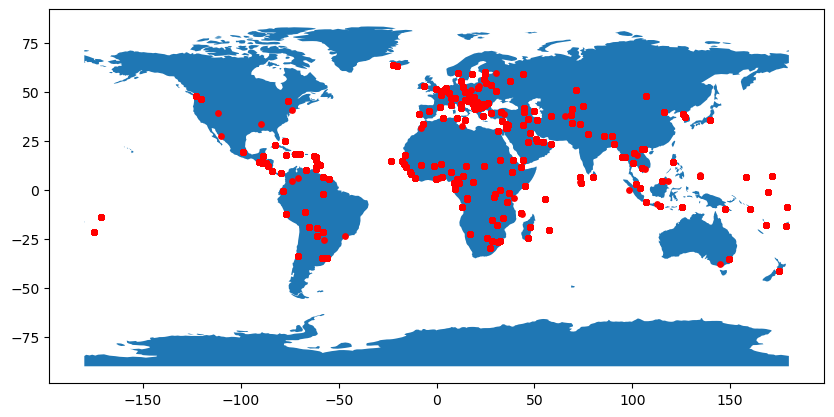

In [5]:
lon_lat = lf.select(["latitude", "longitude"])
geometry = [Point(xy) for xy in zip(lon_lat.select("longitude").collect().to_series(), lon_lat.select("latitude").collect().to_series())]
gdf = GeoDataFrame(lon_lat.collect(), geometry=geometry)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

In [6]:
lf.select("day", "temperature_celsius").group_by("day").mean().collect().plot.line(x="day", y="temperature_celsius")

alt.Chart(...)

In [7]:
nostring_lf = lf.drop("last_updated")
column_names = nostring_lf.collect_schema().names()[1:]
print(column_names)
correlation_matrix_schema = {

    column: pl.Float64 for column in column_names
    
}
correlation_matrix = pl.DataFrame(schema=correlation_matrix_schema)
for column_y in column_names:
    correlation_row = nostring_lf.group_by("location_name").agg(
        [pl.corr(column_x, column_y) for column_x in column_names]
    )
    correlation_matrix = pl.concat([correlation_matrix, correlation_row.drop("location_name").drop_nans().mean().collect()])
correlation_matrix

['latitude', 'longitude', 'temperature_celsius', 'day']


latitude,longitude,temperature_celsius,day
f64,f64,f64,f64
1.0,-0.044529,0.003761,0.004367
-0.044504,1.0,-0.070661,-0.004351
0.003716,-0.070142,1.0,0.066467
0.00439,-0.00441,0.066467,1.0


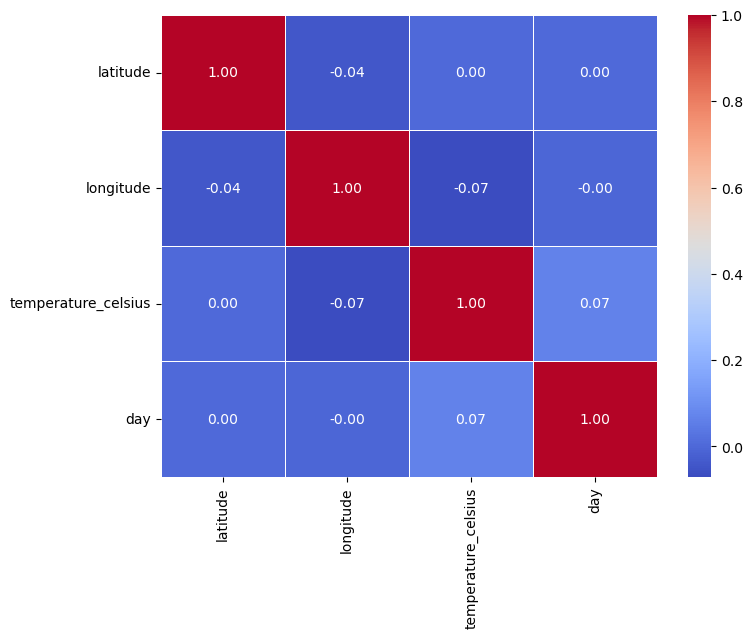

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
columns = correlation_matrix.collect_schema().names()
initial_values = np.asarray(range(len(columns))) + 0.5
plt.xticks(initial_values, columns, rotation="vertical")
plt.yticks(initial_values, columns, rotation="horizontal")
plt.show()

In [9]:
lf = lf.with_columns(

    pl.when(pl.col("latitude") < 0).then(0).otherwise(1).alias("Hemisphere")

)
lf.collect()

location_name,latitude,longitude,last_updated,temperature_celsius,day,Hemisphere
str,f64,f64,str,f64,f64,i32
"""Kabul""",34.52,69.18,"""2024-05-16 13:15""",26.6,137.0,1
"""Tirana""",41.33,19.82,"""2024-05-16 10:45""",19.0,137.0,1
"""Algiers""",36.76,3.05,"""2024-05-16 09:45""",23.0,137.0,1
"""Andorra La Vella""",42.5,1.52,"""2024-05-16 10:45""",6.3,137.0,1
"""Luanda""",-8.84,13.23,"""2024-05-16 09:45""",26.0,137.0,0
…,…,…,…,…,…,…
"""Caracas""",10.5,-66.9167,"""2025-07-01 04:45""",25.0,182.0,1
"""Hanoi""",21.0333,105.85,"""2025-07-01 15:45""",29.2,182.0,1
"""Sanaa""",15.3547,44.2067,"""2025-07-01 11:45""",26.5,182.0,1


In [10]:
lf = lf.with_columns(

    pl.col("last_updated").str.to_datetime("%Y-%m-%d %H:%M").dt.month().cast(pl.Int64).alias("month")

)
lf.collect()

location_name,latitude,longitude,last_updated,temperature_celsius,day,Hemisphere,month
str,f64,f64,str,f64,f64,i32,i64
"""Kabul""",34.52,69.18,"""2024-05-16 13:15""",26.6,137.0,1,5
"""Tirana""",41.33,19.82,"""2024-05-16 10:45""",19.0,137.0,1,5
"""Algiers""",36.76,3.05,"""2024-05-16 09:45""",23.0,137.0,1,5
"""Andorra La Vella""",42.5,1.52,"""2024-05-16 10:45""",6.3,137.0,1,5
"""Luanda""",-8.84,13.23,"""2024-05-16 09:45""",26.0,137.0,0,5
…,…,…,…,…,…,…,…
"""Caracas""",10.5,-66.9167,"""2025-07-01 04:45""",25.0,182.0,1,7
"""Hanoi""",21.0333,105.85,"""2025-07-01 15:45""",29.2,182.0,1,7
"""Sanaa""",15.3547,44.2067,"""2025-07-01 11:45""",26.5,182.0,1,7


In [12]:

lf = lf.with_columns(

    pl.when((pl.col("month") >= 3) & (pl.col("month") <= 5)).then(0)
    .when((pl.col("month") >= 6) & (pl.col("month") <= 8)).then(1)
    .when((pl.col("month") >= 9) & (pl.col("month") <= 11)).then(2)
    .otherwise(3).alias("Season")

)

lf = lf.with_columns(

    pl.when(pl.col("Hemisphere") == 0).then((pl.col("Season") + 2) % 4).otherwise(pl.col("Season")).alias("Corrected Season")
)

lf.collect()

location_name,latitude,longitude,last_updated,temperature_celsius,day,Hemisphere,month,Season,Corrected Season
str,f64,f64,str,f64,f64,i32,i64,i32,i32
"""Kabul""",34.52,69.18,"""2024-05-16 13:15""",26.6,137.0,1,5,0,0
"""Tirana""",41.33,19.82,"""2024-05-16 10:45""",19.0,137.0,1,5,0,0
"""Algiers""",36.76,3.05,"""2024-05-16 09:45""",23.0,137.0,1,5,0,0
"""Andorra La Vella""",42.5,1.52,"""2024-05-16 10:45""",6.3,137.0,1,5,0,0
"""Luanda""",-8.84,13.23,"""2024-05-16 09:45""",26.0,137.0,0,5,0,2
…,…,…,…,…,…,…,…,…,…
"""Caracas""",10.5,-66.9167,"""2025-07-01 04:45""",25.0,182.0,1,7,1,1
"""Hanoi""",21.0333,105.85,"""2025-07-01 15:45""",29.2,182.0,1,7,1,1
"""Sanaa""",15.3547,44.2067,"""2025-07-01 11:45""",26.5,182.0,1,7,1,1


In [13]:
nostring_lf = lf.drop("last_updated", "day", "Hemisphere", "month", "Season")
column_names = nostring_lf.collect_schema().names()[1:]
print(column_names)
correlation_matrix_schema = {

    column: pl.Float64 for column in column_names
    
}
correlation_matrix = pl.DataFrame(schema=correlation_matrix_schema)
for column_y in column_names:
    correlation_row = nostring_lf.group_by("location_name").agg(
        [pl.corr(column_x, column_y) for column_x in column_names]
    )
    correlation_matrix = pl.concat([correlation_matrix, correlation_row.drop("location_name").drop_nans().mean().collect()])
correlation_matrix

['latitude', 'longitude', 'temperature_celsius', 'Corrected Season']


latitude,longitude,temperature_celsius,Corrected Season
f64,f64,f64,f64
1.0,-0.044529,0.003761,0.010205
-0.044504,1.0,-0.070661,0.004607
0.003716,-0.070142,1.0,-0.346617
0.010279,0.004375,-0.346617,1.0


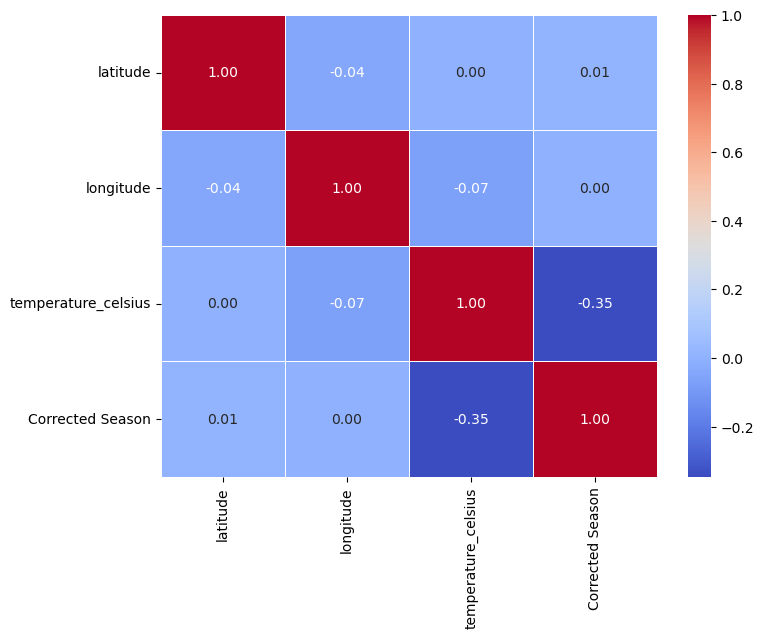

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
columns = correlation_matrix.collect_schema().names()
initial_values = np.asarray(range(len(columns))) + 0.5
plt.xticks(initial_values, columns, rotation="vertical")
plt.yticks(initial_values, columns, rotation="horizontal")
plt.show()

In [15]:
southern_hemisphere = lf.filter(pl.col("Hemisphere") == 0).select("day", "temperature_celsius", "Corrected Season").group_by("day").mean().collect()
southern_hemisphere.plot.point(x="day", y="temperature_celsius", color="Corrected Season")

alt.Chart(...)

In [16]:
northern_hemisphere = lf.filter(pl.col("Hemisphere") == 1).select("day", "temperature_celsius", "Corrected Season").group_by("day").mean().collect()
northern_hemisphere.plot.point(x="day", y="temperature_celsius", color="Corrected Season")

alt.Chart(...)